In [1]:
import sys
sys.path.append('../')
import os
import random

import numpy as np
import torch
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from tqdm import tqdm
from transformers import AutoTokenizer
from data import *
from models.model import MyModel
from modules import *
import omegaconf
import data as data_module
from torchvision import transforms
import matplotlib.pyplot as plt

/opt/pipenv/KLab_MultiModalModel-Zh2ecsZR/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
src_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large", model_max_length=256, use_fast=True)
tgt_tokenizer = AutoTokenizer.from_pretrained(
    "google/flan-t5-large",
    model_max_length=256,
    use_fast=True,
    extra_ids=0,
    additional_special_tokens=[f"<extra_id_{i}>" for i in range(100)]
    + [f"<loc_{i}>" for i in range(1000)]
    + [f"<img_{i}>" for i in range(16384)],
)

# データの設定
task_list = ["cc3m",""]

In [3]:
args = {}
args["root_dir"] = "/home/omote/gpu-node-data01"
args["pretrain"] = True
args["max_source_length"] = 256
args["max_target_length"] = 256
args = omegaconf.OmegaConf.create(args)
cc3m_dataset = data_module.CC3MPretrainDatasetLoader(args,os.path.join(args.root_dir,"cc3m"),phase="val",src_tokenizer = src_tokenizer,tgt_tokenizer=tgt_tokenizer)#get_dataset(args,"cc3m", "val", src_tokenizer, tgt_tokenizer)

In [4]:
print(len(cc3m_dataset))
print(isinstance(cc3m_dataset,torch.utils.data.IterableDataset))


12881
False


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4
tourist attraction the<extra_id_0> gifted by fashion business to the city


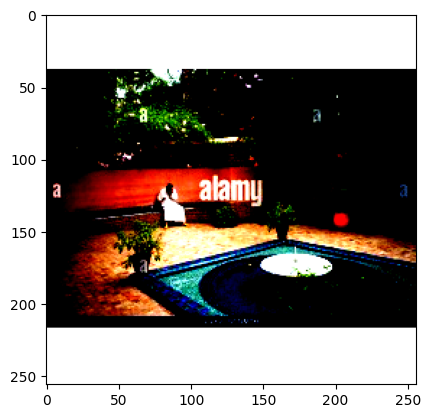

In [5]:
data = cc3m_dataset[100]
plt.imshow(data[0].permute(1,2,0))
print(len(data))
print(data[2])

In [6]:
import os
from copy import deepcopy

import pandas as pd
import torch
from PIL import Image
from torchvision.transforms import ToTensor

# 存在しない画像を除外するためのリスト
dropimageidlist = ["7f1934f5884fad79", "429019e83c1c2c94", "4f818c006da84c9e", "5b86e93f8654118a", "673d74b7d39741c3", "6dcd3ce37a17f2be", "805baf9650a12710"]


class OpenImageDataset_detection(torch.utils.data.Dataset):
    """openimageのdetectionデータセット"""

    def __init__(self, data_dir: str = "/data/dataset/openimage/", phase: str = "train", imagesize: tuple[int, int] = (256, 256)):
        if phase == "val":
            self.phase = "validation"
        else:
            self.phase = phase

        self.data_dir = data_dir
        self.imagesize = imagesize
        self.transform = ToTensor()
        self.not_exist_image = []

        datapath = os.path.join(data_dir, "bbox", f"{self.phase}_detection_40.csv")
        self.df = pd.read_csv(datapath)
        # dropimageidlistに含まれる画像を除外する
        self.df = self.df[self.df["imageID"].isin(dropimageidlist) == False]
        leabelpath = os.path.join(data_dir, "oidv7-class-descriptions.csv")
        self.labels = pd.read_csv(leabelpath)

    # def _return_loc(self,imsize:tuple[int,int],bbox: list[float,float,float,float])->tuple[int,int,int,int]:
    #     """locationを返す

    #     Parameters
    #     ----------
    #     imsize : tuple[int,int]
    #         画像のサイズ
    #     bbox : list[float,float,float,float]
    #         bboxの情報

    #     Returns
    #     -------
    #     x1,x2,y1,y2 : int,int,int,int
    #         locationのタプル
    #     """
    #     x1 = int(imsize[0]*bbox[0])
    #     x2 = int(imsize[0]*bbox[2])
    #     y1 = int(imsize[1]*bbox[1])
    #     y2 = int(imsize[1]*bbox[3])
    #     return x1,x2,y1,y2

    def __getitem__(self, index):
        data = self.df.iloc[index]
        imagepath = os.path.join(self.data_dir, self.phase, data["imageID"] + ".jpg")
        try:
            image = self.transform(Image.open(imagepath).convert("RGB").resize(self.imagesize))
        except:
            self.not_exist_image.append(imagepath)
            print(index,imagepath)
            image = None
        src_text = "What objects are in the image?"
        tgt_text = data["text"]
        return image, src_text, tgt_text

    def __len__(self):
        return len(self.df)

In [7]:

detection_dataset = OpenImageDataset_detection("/home/omote/gpu-node/openimage",phase="val")
print(len(detection_dataset))
print(isinstance(detection_dataset,torch.utils.data.IterableDataset))

36781
False


In [8]:
#11708/36786
#2000から一回回す
# for i in tqdm(range(len(detection_dataset))):
#     data = detection_dataset[i]

In [9]:
print(detection_dataset.not_exist_image)

[]


In [10]:
# detection_dataloader = torch.utils.data.DataLoader(detection_dataset,batch_size=1,shuffle=False,num_workers=1)
# for data in tqdm(detection_dataloader):
#     continue

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3
<loc_80> <loc_1277> Fixed-wing aircraft.


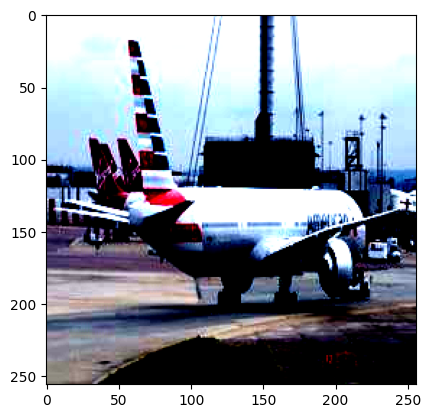

In [11]:
data = next(iter(detection_dataset))
additional_transforms = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225]),
])
plt.imshow(additional_transforms(data[0]).permute(1,2,0))
print(len(data))
print(data[2])

In [12]:
vqa_dataset = data_module.vqa.vqa2.Vqa2dataset("/home/omote/gpu-node/vqa2",phase="val")
print(len(vqa_dataset))
print(isinstance(vqa_dataset,torch.utils.data.IterableDataset))

214354
False


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3
platform


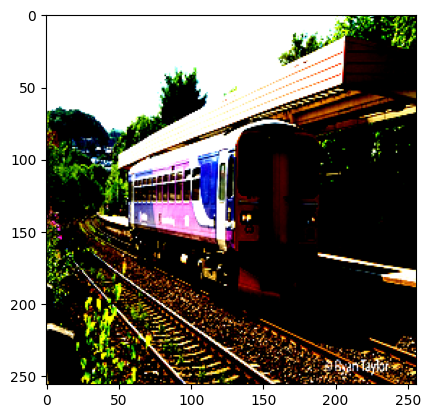

In [13]:
data = vqa_dataset[100]
import matplotlib.pyplot as plt
plt.imshow(additional_transforms(data[0]).permute(1,2,0))
print(len(data))
print(data[2])

In [14]:
coco_dataset = data_module.caption.COCODatasetLoader("/home/omote/gpu-node/mscoco2017",phase="val")
print(len(coco_dataset))
print(isinstance(coco_dataset,torch.utils.data.IterableDataset))

5000
False


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4
tensor([])


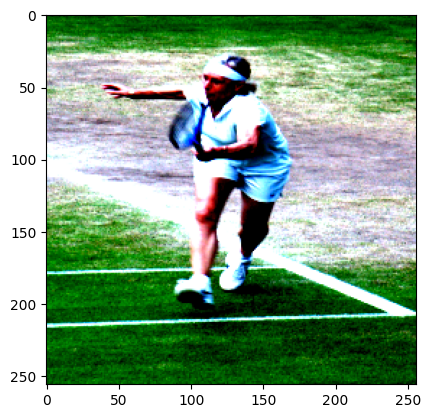

In [15]:
data = coco_dataset[100]
import matplotlib.pyplot as plt
plt.imshow(data[0].permute(1,2,0))
print(len(data))
print(data[1])

In [16]:
coco_dataloader = torch.utils.data.DataLoader(coco_dataset,batch_size=4,shuffle=True,num_workers=1)
next(iter(coco_dataloader))[3]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


('A truck that is sitting in the street.',
 'a man holding a piece of pizza in front of a kid ',
 "A couple of jockey's riding the horses through the beach.",
 'a man riding a blue surfboard on top of a wave.')

In [17]:
import json
# 存在しない画像を除外するためのリスト
dropimageidlist = [
    "7f1934f5884fad79",
    "429019e83c1c2c94",
    "4f818c006da84c9e",
    "5b86e93f8654118a",
    "673d74b7d39741c3",
    "6dcd3ce37a17f2be",
    "805baf9650a12710",
    "98ac2996fc46b56d",
    "a46a248a39f2d97c",
    "9316d4095eab6d10",
    "9ee38bb2e69da0ac",
    "37625d59d0e0782a"
]


class OpenImageDataset_Caption(torch.utils.data.Dataset):
    def __init__(self, data_dir="/data/dataset/openimage", phase="train", imagesize=(256, 256)):
        if phase == "val":
            self.phase = "validation"
        else:
            self.phase = phase
        self.data_dir = data_dir
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
        self.imagesize = imagesize
        self.not_exist_image = []

        with open(os.path.join(self.data_dir, "caption", f"{self.phase}_caption.jsonl"), "r") as f:
            self.items = [json.loads(s) for s in f]

        items = []
        for item in self.items:
            if item["image_id"] not in dropimageidlist:
                items.append(item)
        self.items = items

    def __getitem__(self, idx):
        src_text = "What does the image describe?"
        tgt_text = self.items[idx]["caption"]
        imgpath = os.path.join(self.data_dir, self.phase, f"{self.items[idx]['image_id']}.jpg")
        try:
            image = Image.open(imgpath).convert("RGB").resize(self.imagesize)
            image = self.transform(image)
        except:
            print(imgpath)
            image = None
            self.not_exist_image.append(imgpath)
        return image, src_text, tgt_text

    def __len__(self):
        return len(self.items)

In [18]:
oidv7_caption_dataset = OpenImageDataset_Caption("/home/omote/gpu-node/openimage",phase="val")
print(len(oidv7_caption_dataset))
print(isinstance(oidv7_caption_dataset,torch.utils.data.IterableDataset))

41680
False


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[-0.6623, -0.5301, -1.0027],
         [-0.6281, -0.4951, -0.9678],
         [-0.5938, -0.4601, -0.9330],
         ...,
         [-0.5938, -0.3550, -1.0201],
         [-0.5767, -0.3375, -1.0027],
         [-0.5424, -0.3025, -0.9678]],

        [[-0.6281, -0.5301, -0.9853],
         [-0.6109, -0.5126, -0.9853],
         [-0.6281, -0.5301, -1.0027],
         ...,
         [-0.5253, -0.3025, -0.9330],
         [-0.5424, -0.3200, -0.9504],
         [-0.5253, -0.3025, -0.9330]],

        [[-0.6109, -0.5476, -1.0027],
         [-0.6109, -0.5476, -1.0027],
         [-0.6623, -0.5826, -1.0376],
         ...,
         [-0.4739, -0.2500, -0.8458],
         [-0.4568, -0.2325, -0.8458],
         [-0.4568, -0.2325, -0.8284]],

        ...,

        [[ 0.6906,  0.7829,  1.1934],
         [ 0.7077,  0.8004,  1.2108],
         [ 0.6906,  0.7829,  1.1934],
         ...,
         [ 0.8789,  1.0105,  1.3328],
         [ 0.8789,  1.0105,  1.3328],
         [ 0.8789,  1.0105,  1.3328]],

        [[

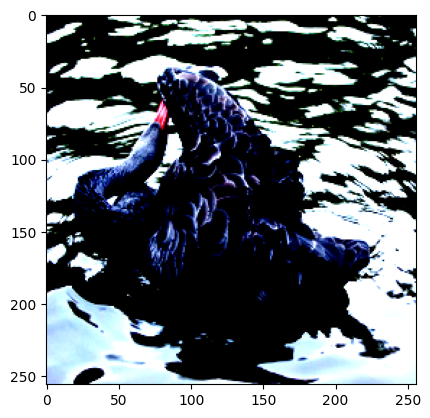

3


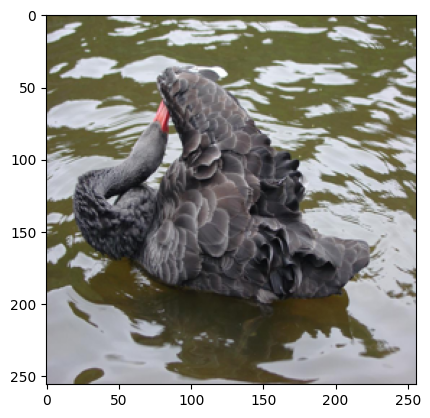

In [41]:
data = oidv7_caption_dataset[100]
import matplotlib.pyplot as plt
plt.imshow(data[0].permute(1,2,0))
print(data[0].permute(1,2,0))
plt.show()
print(len(data))
# print(data[2])
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img = data[0]
img = img * torch.tensor(std).view(3, 1, 1)
img = img + torch.tensor(mean).view(3, 1, 1)
img = transforms.ToPILImage()(img)
plt.imshow(img)
plt.show()
import numpy as np
# print(np.array(img))

In [20]:
# for i in tqdm(range(len(oidv7_caption_dataset))):
#     data = oidv7_caption_dataset[i]

100%|██████████| 41680/41680 [20:42<00:00, 33.55it/s]  


In [ ]:
# print(oidv7_caption_dataset.not_exist_image)

In [21]:
a = {"a":1,"b":2,"c":3}
indexes = ["a","c"]
item = [a[i] for i in indexes]
print(item)

[1, 3]


In [22]:
a= [10,11,12]
b=[0,2]
item = [a[i] for i in b]
print(item)

[10, 12]


In [23]:
caption_dataset = data_module.MultiChainDataset(dataset_list=[coco_dataset, oidv7_caption_dataset], key_list=[[0, 2, 3], [0, 1, 2]])
caption_dataloader = torch.utils.data.DataLoader(caption_dataset,batch_size=4,shuffle=True,num_workers=1)


In [24]:
caption_iter = iter(caption_dataloader)
for i in range(10):
    print(i)
    data = next(caption_iter)
    print(len(data))
    print(data[0].shape)
    print(data[1])
    print(data[2])
    

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
0


3
torch.Size([4, 3, 256, 256])
('What does the image describe?', 'What does the image describe?', 'What does the image describe ?', 'What does the image describe ?')
('In this image we can see bees on the plants and there are flowers.', 'In this image we can see in front there are two people paragliding, the sky is at the top.', 'A box full of matching, ridged donuts with glaze.', 'Yellow Train stopped at the station in front of a bench.  ')
1
3
torch.Size([4, 3, 256, 256])
('What does the image describe?', 'What does the image describe?', 'What does the image describe?', 'What does the image describe?')
('In this image I can see the boards with some text written on it. I can see a car on the ground. In the background, I can see the wall.', 'This is an image of a desert,where we can see some bushes and in background we can see a mountain range.', 'In this image I can see bowl with some food item and in the background I can see something looking like keyboard.', 'The picture consists of